## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()
#df.info()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [5]:
#df.drop_duplicates(subset='user_id',inplace=True)
np.round(df.converted.sum()/len(df),2)

0.12

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.groupby(['group','landing_page']).size()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=pd.read_csv('ab_data.csv')
df2.shape

(294478, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
#df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new

df2.head()
df2=pd.concat([df2.query('group=="treatment" & landing_page=="new_page"'),
          df2.query('group=="control" & landing_page=="old_page"')])

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
print(len(df2.user_id))


290585


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(subset='user_id') == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset='user_id',inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
np.round(df2['converted'].sum()/len(df2),4)


0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
temper=df2.query('group=="control"')
np.round(temper.converted.sum()/len(temper),4)

0.12039999999999999

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
temper=df2.query('group=="treatment"')
np.round(temper.converted.sum()/len(temper),4)

0.1188

d. What is the probability that an individual received the new page?

In [17]:
temper=df2.query('landing_page=="new_page"')
np.round(len(temper)/len(df2),4)

0.50009999999999999

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

<font color='green'>**The probability of converting of  treatment group is 0.120 and probability of  converting of  the control group is 0.118 . So, The old page conversion rate is better than the new page conversion rate.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Null Hypothses :  P𝑜𝑙𝑑 <= P𝑛𝑒𝑤  
#### Alternative Hypothesis: P𝑜𝑙𝑑 > P𝑛𝑒𝑤
#### alpha = 0.05




`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new= df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = len(df2.query('group == "treatment"'))
n_new
#df2.groupby(['group','landing_page']).size()

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
np.random.seed(39)
new_page_converted=np.random.binomial(1,p = p_new,size = n_new)
new_page_converted




array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
np.random.seed(39)
old_page_converted=np.random.binomial(1,p=p_old,size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
p_diff_obs = np.mean(new_page_converted)-np.mean(old_page_converted)
p_diff_obs

2.5301087033330338e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
i=1
p_diffs=[]
while i<=10000:
    new_page_converted=np.random.binomial(1,p = p_new,size = n_new)
    old_page_converted=np.random.binomial(1,p=p_old,size=n_old)
    p_diff_obs=np.mean(new_page_converted)-np.mean(old_page_converted)
    p_diffs.append(p_diff_obs)
    i+=1
#p_diffs

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  1.50000000e+01,   1.24000000e+02,   7.65000000e+02,
          2.02000000e+03,   3.25000000e+03,   2.57800000e+03,
          9.91000000e+02,   2.23000000e+02,   3.20000000e+01,
          2.00000000e+00]),
 array([-0.00473056, -0.00371607, -0.00270158, -0.00168708, -0.00067259,
         0.00034191,  0.0013564 ,  0.0023709 ,  0.00338539,  0.00439989,
         0.00541438]),
 <a list of 10 Patch objects>)

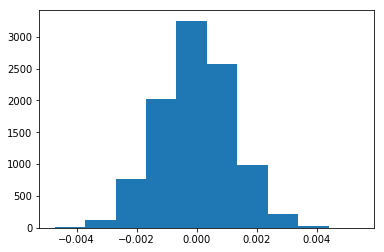

In [26]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
act_p_new=df2[df2['group']=="treatment"]['converted'].mean()
act_p_old=df2[df2['group']=="treatment"]['converted'].mean()
act_p_diff=act_p_new-act_p_old
p_value=(p_diffs>act_p_diff).mean()
p_value


0.49349999999999999

p_value is a measure of the probability that a more extreme condition will occur than the existing distribution under the null hypothesis.
p_value >alpha(0.05),so we can't reject Null Hypothesis. so we can infer that theres no difference convert propotion between new and old pages.

**_value is a measure of the probability that a more extreme condition will occur than the existing distribution under the null hypothesis. p_value >alpha(0.05),so we can't reject Null Hypothesis. so we can infer that theres no difference convert propotion between new and old pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page"').converted.sum()
convert_new = df2.query('landing_page=="new_page"').converted.sum()
n_old =len(df2.query('landing_page=="old_page"'))
n_new = len(df2.query('landing_page=="new_page"'))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
from statsmodels.stats.proportion import proportions_ztest
z_statistic,p_value =proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger') 
print(z_statistic)
print(p_value)
from scipy.stats import norm
z=norm.ppf(1-0.05)
print(z)
if z_statistic<z:
    print("Can't reject The Null  Hypothesis")
#print(norm.cdf(z_statistic))


-1.31092419842
0.905058312759
1.64485362695
Can't reject The Null  Hypothesis


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z_score is-1.31092419842，and p_value is 0.905058312759,also z_statistic <z  ,so we can't reject the NUll hypothesis , 
they agree with the finding s in part **j.** and **k.** **

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color ='grenn'>**I will choose Logistic Regression  to perform this case. Logistic regression model is a very useful classify tool.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = df2['group'].map(lambda x :np.where(x=='treatment',1,0))
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
from scipy import stats
import statsmodels.api as sm
logistic_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=logistic_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        05:50:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

<font color='green'>**p_value associated with ab_page is 0.19 ,while p_value in part II is 0.905. Even though they are different ,they are all larger than alpha(0.05), which means that the Null Hypothesis can' t be rejected, that is, the conversion rate of old pages is lower or equal than that of new pages. Need to be noticed is that P_value in part two ,is test by one sided test ,but here is test by two sided test.**
 1.  null hypothese : p_new=p_old 
 2. alternative hypothese :p_new!=p_old 
    

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<font color='green'> 1. I think it's a good idea to add other influnence factors in to the logistic model.When more factors are taken considered ,the more sample unbalance can be reduced.If we only taken one or two elements ,we may neglect some important factors that influence the converted rate.
2. The disaddvantages is that if we add more than 10%* volum of smallgroup ,partial regression coefficient would be larger.
3.  When we add variables, we need to take to caculate the Residual error ,if   the Residual error be larger ,it should not add it.
    Also ,we delelte the varibele we already added  to the model ,then check the Residual error to decied whether del oo not. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries=pd.read_csv('countries.csv')
#countries.country.unique()
df3=pd.merge(df2,countries,left_on='user_id',right_on='user_id')
df3[['UK','US']] = pd.get_dummies(df3.country,drop_first=True)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [34]:
import statsmodels.api as sm
x_var=['intercept','ab_page','UK','US']
logistic=sm.Logit(df3['converted'],df3[x_var])
result=logistic.fit()
print(result)
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Jan 2020   Pseudo R-squ.:               2.323e-05
Time:                        05:50:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

<font color='green'>**With the baseline of  CA,  the result shows that there no difference of the convert rate when people from different country and use different pages.**

In [35]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0